<a href="https://colab.research.google.com/github/AI4Finance-LLC/FinRL-Library/blob/master/FinRL_multiple_stock_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

Tutorials to use OpenAI DRL to trade multiple stocks in one Jupyter Notebook | Presented at NeurIPS 2020: Deep RL Workshop

* This blog is based on our paper: FinRL: A Deep Reinforcement Learning Library for Automated Stock Trading in Quantitative Finance, presented at NeurIPS 2020: Deep RL Workshop.
* Check out medium blog for detailed explanations: https://towardsdatascience.com/finrl-for-quantitative-finance-tutorial-for-multiple-stock-trading-7b00763b7530
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- ASSUMES USING DOCKER, see readme for instructions

<a id='1.1'></a>
## 2.1. Add FinRL to your path. You can of course install it as a pipy package, but this is for development purposes.


In [1]:
import sys

sys.path.append("..")


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_stocktrading import StockTradingEnv
from finrl.model.models import DRLAgent
from finrl.trade.backtest import BackTestStats, BaselineStats, BackTestPlot

from pprint import pprint




/opt/conda/lib/python3.6/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


<a id='1.4'></a>
## 2.4. Create Folders

In [3]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [4]:
# from config.py start_date is a string
config.START_DATE

'2009-01-01'

In [5]:
# from config.py end_date is a string
config.END_DATE

'2020-12-01'

In [6]:
print(config.DOW_30_TICKER)

['AAPL', 'MSFT', 'JPM', 'V', 'RTX', 'PG', 'GS', 'NKE', 'DIS', 'AXP', 'HD', 'INTC', 'WMT', 'IBM', 'MRK', 'UNH', 'KO', 'CAT', 'TRV', 'JNJ', 'CVX', 'MCD', 'VZ', 'CSCO', 'XOM', 'BA', 'MMM', 'PFE', 'WBA', 'DD']


In [7]:
df = YahooDownloader(start_date = '2009-01-01',
                     end_date = '2021-01-01',
                     ticker_list = config.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [8]:
df.shape

(90630, 8)

In [9]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.795913,746015200.0,AAPL,4
1,2009-01-02,18.570000,19.520000,18.400000,15.745411,10955700.0,AXP,4
2,2009-01-02,42.799999,45.560001,42.779999,33.680935,7010200.0,BA,4
3,2009-01-02,44.910000,46.980000,44.709999,32.514400,7117200.0,CAT,4
4,2009-01-02,16.410000,17.000000,16.250000,12.683227,40980600.0,CSCO,4


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [10]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added turbulence index


In [11]:
processed.sort_values(['date','tic'],ignore_index=True).head(10)

,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30,turbulence
0,2009-01-02,3.067143,3.251429,3.041429,2.795913,746015200.0,AAPL,4,0.0,100.0,66.666667,100.0,0.0
1,2009-01-02,18.570000,19.520000,18.400000,15.745411,10955700.0,AXP,4,0.0,100.0,66.666667,100.0,0.0
2,2009-01-02,42.799999,45.560001,42.779999,33.680935,7010200.0,BA,4,0.0,100.0,66.666667,100.0,0.0
3,2009-01-02,44.910000,46.980000,44.709999,32.514400,7117200.0,CAT,4,0.0,100.0,66.666667,100.0,0.0
4,2009-01-02,16.410000,17.000000,16.250000,12.683227,40980600.0,CSCO,4,0.0,100.0,66.666667,100.0,0.0
5,2009-01-02,74.230003,77.300003,73.580002,48.043262,13695900.0,CVX,4,0.0,100.0,66.666667,100.0,0.0
6,2009-01-02,21.605234,22.060680,20.993229,14.527276,13251000.0,DD,4,0.0,100.0,66.666667,100.0,0.0
7,2009-01-02,22.760000,24.030001,22.500000,20.597496,9796600.0,DIS,4,0.0,100.0,66.666667,100.0,0.0
8,2009-01-02,84.019997,87.620003,82.190002,72.844467,14088500.0,GS,4,0.0,100.0,66.666667,100.0,0.0
9,2009-01-02,23.070000,24.190001,22.959999,17.909452,14902500.0,HD,4,0.0,100.0,66.666667,100.0,0.0


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## Training data split: 2009-01-01 to 2018-12-31
## Trade data split: 2019-01-01 to 2020-09-30

In [12]:
train = data_split(processed, '2009-01-01','2019-01-01')
trade = data_split(processed, '2019-01-01','2021-01-01')
print(len(train))
print(len(trade))

75480
15150


In [13]:
train.head()

,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30,turbulence
0,2009-01-02,3.067143,3.251429,3.041429,2.795913,746015200.0,AAPL,4,0.0,100.0,66.666667,100.0,0.0
0,2009-01-02,18.570000,19.520000,18.400000,15.745411,10955700.0,AXP,4,0.0,100.0,66.666667,100.0,0.0
0,2009-01-02,42.799999,45.560001,42.779999,33.680935,7010200.0,BA,4,0.0,100.0,66.666667,100.0,0.0
0,2009-01-02,44.910000,46.980000,44.709999,32.514400,7117200.0,CAT,4,0.0,100.0,66.666667,100.0,0.0
0,2009-01-02,16.410000,17.000000,16.250000,12.683227,40980600.0,CSCO,4,0.0,100.0,66.666667,100.0,0.0


In [14]:
trade.head()

,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30,turbulence
0,2019-01-02,38.722500,39.712502,38.557499,38.562561,148158800.0,AAPL,2,-2.019903,37.867349,-91.567852,42.250808,51.36772
0,2019-01-02,93.910004,96.269997,93.769997,92.319603,4175400.0,AXP,2,-3.414037,41.205002,-97.751316,26.709417,51.36772
0,2019-01-02,316.190002,323.950012,313.709991,314.645142,3292200.0,BA,2,-5.550592,47.010000,-21.712382,13.611972,51.36772
0,2019-01-02,124.029999,127.879997,123.000000,119.302582,4783200.0,CAT,2,-0.686759,48.229089,-5.091209,0.873482,51.36772
0,2019-01-02,42.279999,43.200001,42.209999,40.057236,23833500.0,CSCO,2,-0.952338,44.872557,-87.518839,29.529377,51.36772


In [15]:
config.TECHNICAL_INDICATORS_LIST

['macd', 'rsi_30', 'cci_30', 'dx_30']

In [16]:
print(StockTradingEnv.__doc__)


    A stock trading environment for OpenAI gym
    Parameters:
    state space: {start_cash, <owned_shares>, for s in stocks{<stock.values>}, }
        df (pandas.DataFrame): Dataframe containing data
        transaction_cost (float): cost for buying or selling shares
        hmax (int): max number of share purchases allowed per asset
        turbulence_threshold (float): Maximum turbulence allowed in market for purchases to occur. If exceeded, positions are liquidated
        print_verbosity(int): When iterating (step), how often to print stats about state of env
        reward_scaling (float): Scaling value to multiply reward by at each step. 
        initial_amount: (int, float): Amount of cash initially available
        daily_information_columns (list(str)): Columns to use when building state space from the dataframe. 
        out_of_cash_penalty (int, float): Penalty to apply if the algorithm runs out of cash
    


    tests:
        after reset, static strategy should result i

#### state space
The state space of the observation is as follows 

`start_cash, <owned_shares_of_n_assets>, <<indicator_i_for_asset_j> for j in assets>`

indicators are any daily measurement you can achieve. Common ones are 'volume', 'open' 'close' 'high', 'low'.
However, you can add these as needed, 
The feature engineer adds indicators, and you can add your own as well. 


In [17]:
information_cols = ['open', 'high', 'low', 'close', 'volume', 'day', 'macd', 'rsi_30', 'cci_30', 'dx_30', 'turbulence']

e_train_gym = StockTradingEnv(df = train, 
                              hmax = 100, 
                              out_of_cash_penalty=-2e6,
                              daily_information_cols = information_cols,
                              print_verbosity = 500)

## Environment for Training
There are two available environments. The multiprocessing and the single processing env. 
Some models won't work with multiprocessing. 

```python
# single processing
env_train, _ = e_train_gym.get_sb_env()


#multiprocessing
env_train, _ = e_train_gym.get_multiproc_env(n = <n_cores>)
```


In [18]:
# for this example, let's do multiprocessing with n_cores-2

import multiprocessing

n_cores = multiprocessing.cpu_count() - 2
n_cores = 20
print(f"using {n_cores} cores")


env_train, _ = e_train_gym.get_multiproc_env(n = n_cores)
# env_train, _ = e_train_gym.get_sb_env()

using 20 cores
EPISODE |STEPS     |TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARDEPISODE |STEPS     |TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARDEPISODE |STEPS     |TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARDEPISODE |STEPS     |TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARDEPISODE |STEPS     |TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARDEPISODE |STEPS     |TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARDEPISODE |STEPS     |TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARDEPISODE |STEPS     |TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARDEPISODE |STEPS     |TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARDEPISODE |STEPS     |TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARDEPISODE |STEPS     |TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARDEPISODE |STEPS     |TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARDEPISODE |STEPS     |TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARDEPISODE |STEPS     |TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARDEPISODE |STEPS     |TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARDEPISODE |STEPS     |TERMINAL_REASON|TOT_ASSETS|TERMINAL

<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [19]:
agent = DRLAgent(env = env_train)

In [20]:
print(config.A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}


### Model Training: 5 models, A2C DDPG, PPO, TD3, SAC


### Model 1: A2C


In [22]:
a2c_params = {
    "ent_coef": 0.01, 
    "learning_rate": 1e-3,
    "n_steps": 10
    
}

model = agent.get_model("a2c",  model_kwargs = a2c_params)

{'ent_coef': 0.01, 'learning_rate': 0.001, 'n_steps': 10}
Using cuda device


In [ ]:
model.learn(total_timesteps = 2000000, 
            log_interval = 100, tb_log_name = 'docker_notebook_again',
            reset_num_timesteps = False)

Logging to tensorboard_log/a2c/docker_notebook_again_0
------------------------------------
| time/                 |          |
|    fps                | 19270    |
|    iterations         | 100      |
|    time_elapsed       | 104      |
|    total_timesteps    | 2020000  |
| train/                |          |
|    entropy_loss       | -66.9    |
|    explained_variance | -0.00398 |
|    learning_rate      | 0.001    |
|    n_updates          | 10099    |
|    policy_loss        | 0.188    |
|    std                | 2.26     |
|    value_loss         | 2.05     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 9484     |
|    iterations         | 200      |
|    time_elapsed       | 215      |
|    total_timesteps    | 2040000  |
| train/                |          |
|    entropy_loss       | -67.1    |
|    explained_variance | 0.073    |
|    learning_rate      | 0.001    |
|    n_updates      

In [ ]:
data_turbulence = processed[(processed.date<'2019-01-01') & (processed.date>='2009-01-01')]
insample_turbulence = data_turbulence.drop_duplicates(subset=['date'])

In [ ]:
insample_turbulence.turbulence.describe()

In [ ]:
turbulence_threshold = np.quantile(insample_turbulence.turbulence.values,1)

In [ ]:
turbulence_threshold

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2018-12 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [24]:
trade = data_split(processed, '2019-01-01','2021-01-01')
e_trade_gym = StockTradingEnv(df = trade,hmax = 100, 
                              daily_information_cols = information_cols,
                              print_verbosity = 500)
env_trade, obs_trade = e_trade_gym.get_sb_env()

df_account_value, df_actions = DRLAgent.DRL_prediction(model=model,
                        test_data = trade,
                        test_env = env_trade,
                        test_obs = obs_trade)

EPISODE |STEPS     |TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARD
       1|       499|update         |$1005004|-1.1818220905827592
       1|       504|Last Date      |$1004682|-0.6066134418063681
hit end!


In [25]:
df_account_value.shape

(505, 4)

In [26]:
df_account_value.head()

,cash,asset_value,total_assets,date
0,1000000.000000,0.000000,1000000.000000,2019-01-02
1,1000000.000000,0.000000,1000000.000000,2019-01-03
2,856009.061879,139609.078526,995618.140405,2019-01-04
3,960426.621214,36070.433011,996497.054225,2019-01-07
4,971772.292440,24543.500928,996315.793368,2019-01-08


In [27]:
df_actions.head()

,date,actions
0,2019-01-02,"[-100.0, -100.0, 100.0, 100.0, 100.0, 100.0, -..."
1,2019-01-03,"[-100.0, -100.0, -100.0, 1.6715765, -100.0, -1..."
2,2019-01-04,"[-100.0, -100.0, -100.0, -100.0, -100.0, -100...."
3,2019-01-07,"[-100.0, -100.0, -100.0, -100.0, -100.0, -100...."
4,2019-01-08,"[-100.0, -100.0, -100.0, 10.887527, -100.0, -1..."


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [28]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = BackTestStats(account_value=df_account_value, value_col_name = 'total_assets')
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
annual return:  1.0004311372012076
sharpe ratio:  0.08055356268546879
Annual return          0.002338
Cumulative returns     0.004682
Annual volatility      0.123580
Sharpe ratio           0.080554
Calmar ratio           0.016769
Stability              0.012354
Max drawdown          -0.139449
Omega ratio            1.017406
Sortino ratio          0.116217
Skew                   0.092149
Kurtosis               7.106414
Tail ratio             1.120924
Daily value at risk   -0.015530
Alpha                  0.000000
Beta                   1.000000
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
annual return:  1.0004311372012076
sharpe ratio:  0.08055356268546879
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (505, 8)


Start date,2019-01-03
End date,2020-12-31
Total months,24
,Backtest
Annual return,0.234%
Cumulative returns,0.468%
Annual volatility,12.358%
Sharpe ratio,0.08
Calmar ratio,0.02
Stability,0.01
Max drawdown,-13.945%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,13.94,2019-07-05,2020-03-24,2020-11-10,353
1,9.52,2020-12-09,2020-12-31,NaT,NaN
2,3.03,2020-11-10,2020-11-17,2020-12-01,16
3,1.47,2019-01-03,2019-04-23,2019-06-11,114
4,1.17,2020-12-03,2020-12-04,2020-12-08,4


/opt/conda/lib/python3.6/site-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


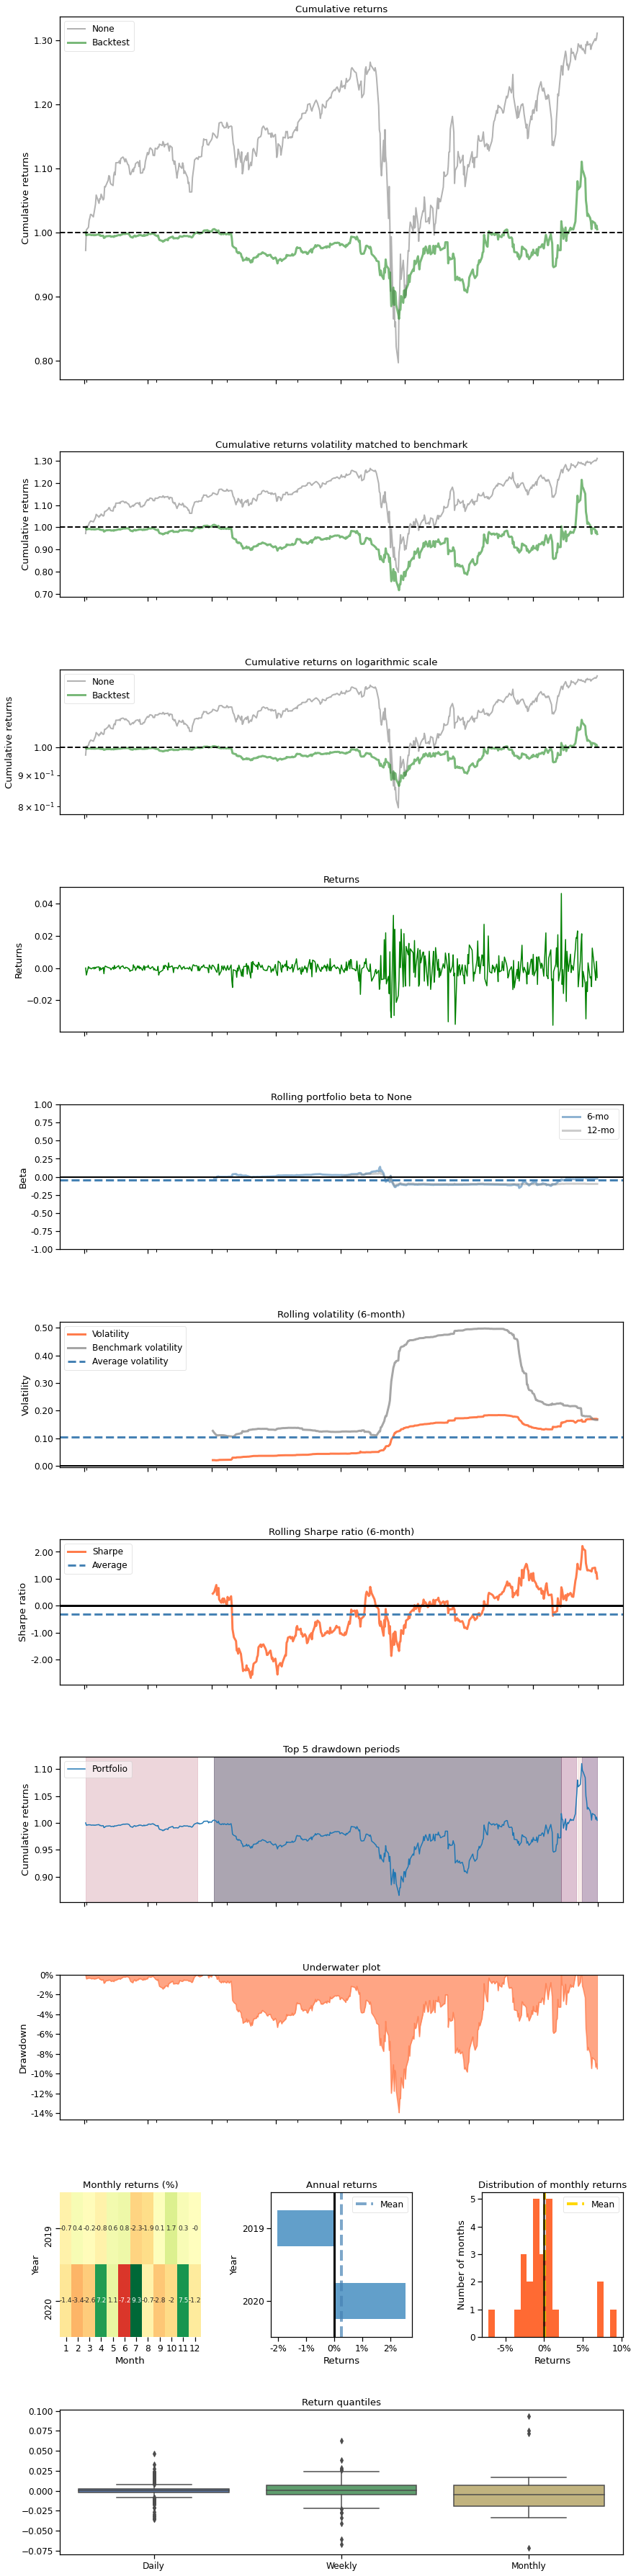

In [29]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
BackTestPlot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = '2019-01-01',
             baseline_end = '2021-01-01', value_col_name = 'total_assets')

<a id='6.3'></a>
## 7.3 Baseline Stats

In [30]:
print("==============Get Baseline Stats===========")
baesline_perf_stats=BaselineStats('^DJI',
                                  baseline_start = '2019-01-01',
                                  baseline_end = '2021-01-01')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (505, 8)
Annual return          0.144674
Cumulative returns     0.310981
Annual volatility      0.274619
Sharpe ratio           0.631418
Calmar ratio           0.390102
Stability              0.116677
Max drawdown          -0.370862
Omega ratio            1.149365
Sortino ratio          0.870084
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.860710
Daily value at risk   -0.033911
Alpha                  0.000000
Beta                   1.000000
dtype: float64
